In [1]:
import geopandas as gpd
import contextily as ctx
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests
from shapely.geometry import box
import gstools as gs
import numpy as np
import geopandas as gpd
from sklearn.cluster import DBSCAN

In [3]:
# Set the file path where you want to save the data
data_file = 'data/mosquito-alert.csv'

# Ensure the directory exists
os.makedirs(os.path.dirname(data_file), exist_ok=True)

# Direct link to the raw data file on GitHub
url = 'https://raw.githubusercontent.com/janneheusler/monarch-butterfly-experimental-variogram/refs/heads/main/monarch%20butterflies.csv'

# Download the file and save it locally
response = requests.get(url)
if response.status_code == 200:
    with open(data_file, 'wb') as f:
        f.write(response.content)
    print("Data downloaded and saved locally.")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

# Now you can load the data
import pandas as pd
df = pd.read_csv(data_file)
df.head()

Data downloaded and saved locally.


,sighting_date,species,number,latitude,longitude,flag_number,species_old,flag_species
0,1996-12-16,Monarch Adult Sighted,1,27.594,-81.362,1,Monarch Butterfly,1
1,1996-12-06,Monarch Adult Sighted,1,30.420,-87.224,1,Monarch Butterfly,1
2,1996-09-21,Monarch Adult Sighted,1,40.817,-96.710,1,Monarch Butterfly,1
3,1996-09-21,Monarch Adult Sighted,1,40.817,-96.710,1,Monarch Butterfly,1
4,1997-01-01,Monarch Adult Sighted,1,34.244,-77.946,1,Monarch Butterfly,1


In [6]:
# Convert the 'sighting_date' column to datetime format for filtering
df['sighting_date'] = pd.to_datetime(df['sighting_date'], errors='coerce')

# Filter the data for entries in the year 2020
df_2020 = df[df['sighting_date'].dt.year == 2020]


In [7]:
# Filter the data for the months March, April, May, June, July, and August in 2020
df_spring_summer_2020 = df_2020[df_2020['sighting_date'].dt.month.isin([3, 4, 5, 6, 7, 8])]

df_spring_summer_2020.head()


,sighting_date,species,number,latitude,longitude,flag_number,species_old,flag_species
89166,2020-03-01,Monarch Adult Sighted,1,28.000,-82.752,0,Monarch Adult Sighted,0
89167,2020-03-01,Monarch Adult Sighted,1,29.883,-97.941,0,Monarch Adult Sighted,0
89169,2020-03-02,Monarch Adult Sighted,1,33.513,-79.062,0,Monarch Adult Sighted,0
89170,2020-03-01,Monarch Adult Sighted,2,27.489,-82.630,0,Monarch Adult Sighted,0
89171,2020-03-04,Monarch Adult Sighted,1,36.974,-122.031,0,Monarch Adult Sighted,0


In [8]:
# Calculate the 0.1 and 0.9 quantiles for the 'number' column
q10 = df_spring_summer_2020['number'].quantile(0.1)
q90 = df_spring_summer_2020['number'].quantile(0.9)

# Filter the data based on the 0.25 and 0.75 quantiles
df_filtered_quantiles = df_spring_summer_2020[(df_spring_summer_2020['number'] >= q10) & (df_spring_summer_2020['number'] <= q90)]

# Display the number of observations remaining after filtering
df_filtered_quantiles.shape[0], q10, q90


(5905, 1.0, 4.0)

In [9]:
# Create a GeoDataFrame from the filtered dataset
gdf_filtered = gpd.GeoDataFrame(df_filtered_quantiles, geometry=gpd.points_from_xy(df_filtered_quantiles['longitude'], df_filtered_quantiles['latitude']))

# Set the CRS to WGS84 (EPSG:4326)
gdf_filtered.set_crs(epsg=4326, inplace=True)

# Convert to a projected CRS for distance-based clustering (EPSG:3857 - Web Mercator)
gdf_projected = gdf_filtered.to_crs(epsg=3857)

# Extract coordinates in meters for clustering
coords = np.array(list(zip(gdf_projected.geometry.x, gdf_projected.geometry.y)))

# Set a distance threshold of 50 kilometers (50,000 meters) for DBSCAN
db = DBSCAN(eps=50000, min_samples=5, algorithm='ball_tree', metric='euclidean').fit(coords)

# Add the cluster labels to the original GeoDataFrame
gdf_filtered['cluster'] = db.labels_

# Aggregate the data based on the clusters
cluster_aggregation = gdf_filtered.groupby('cluster')['number'].sum().reset_index()

# Display the aggregated data
cluster_aggregation.head()

,cluster,number
0,-1,807
1,0,94
2,1,287
3,2,7
4,3,244


In [10]:
# For each cluster, calculate the centroid of the points within that cluster

# First, filter out the noise points (cluster == -1) as they don't belong to any cluster
gdf_clusters = gdf_filtered[gdf_filtered['cluster'] != -1]

# Group by cluster and calculate the centroid (mean of latitude and longitude) for each cluster
cluster_centroids = gdf_clusters.groupby('cluster').agg(
    centroid_longitude=('longitude', 'mean'),
    centroid_latitude=('latitude', 'mean'),
    total_observations=('number', 'sum')
).reset_index()

# Display the centroids and aggregated data for each cluster
cluster_centroids.head()

,cluster,centroid_longitude,centroid_latitude,total_observations
0,0,-82.185312,28.287234,94
1,1,-98.019015,30.275975,287
2,2,-86.386143,30.385143,7
3,3,-95.494076,29.872035,244
4,4,-97.393711,27.793737,51


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


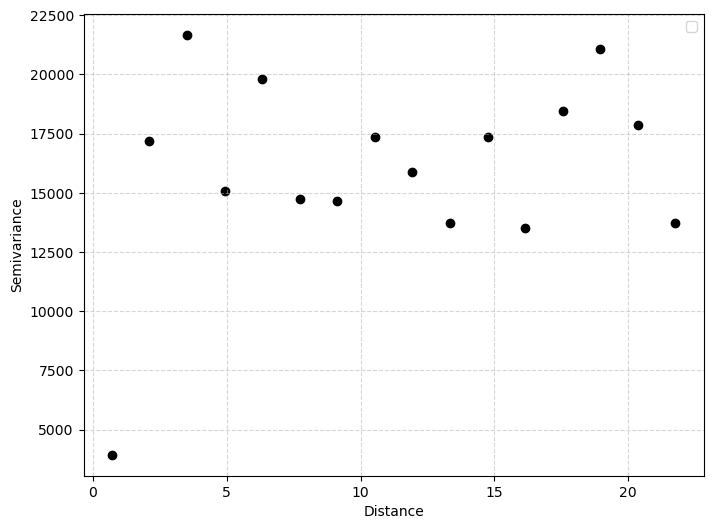

In [11]:
# Extract the coordinates (centroid latitude and longitude) and the total number of observations
x_coords = cluster_centroids['centroid_longitude'].values
y_coords = cluster_centroids['centroid_latitude'].values
observation_counts = cluster_centroids['total_observations'].values

# Step 1: Calculate the variance of the observation counts
observations_variance = np.var(observation_counts)

# Step 2: Define the variogram model with the calculated variance
model = gs.Exponential(dim=2, var=observations_variance)
bin_center, gamma = gs.vario_estimate((x_coords, y_coords), observation_counts)

# Fit a model to the experimental variogram
fit_model = gs.Exponential(dim=2)
fit_model.fit_variogram(bin_center, gamma, nugget=False)

# Plot the variogram
# Plot the variogram
plt.figure(figsize=(8, 6))
plt.scatter(bin_center, gamma, color='black')  # Black dots
plt.xlabel("Distance", color='black')
plt.ylabel("Semivariance", color='black')
plt.grid(True, linestyle='--', alpha=0.5)  # Optional: add a grid with dashed lines
plt.legend()

plt.show()
